In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
base_image_path = 'http://guereak.com/nst/base_image_1.jpg'
style_reference_image_path_1 = 'http://guereak.com/nst/style_transfer_1.jpg'
style_reference_image_path_2 = 'http://guereak.com/nst/style_transfer_2.jpg'
style_reference_image_path_3 = 'http://guereak.com/nst/style_transfer_3.jpg'
style_reference_image_path_4 = 'http://guereak.com/nst/style_transfer_4.jpg'

style_reference_image_path = style_reference_image_path_3

2128819/2128819 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


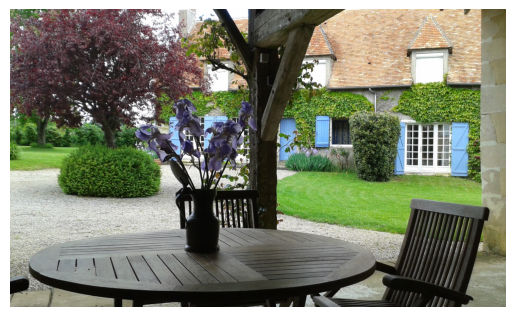

In [5]:
base_image_path = mpimg.imread(base_image_path)
plt.imshow(base_image_path)
plt.axis('off')
plt.show()

575046/575046 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
943128/943128 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(3, 400, 533, 3))
  warnings.warn(msg)


Iteration 100: loss=8138.22
Iteration 200: loss=6652.97
Iteration 300: loss=6062.85
Iteration 400: loss=5742.04
Iteration 500: loss=5535.25
Iteration 600: loss=5389.49
Iteration 700: loss=5280.02
Iteration 800: loss=5194.52
Iteration 900: loss=5125.66
Iteration 1000: loss=5068.84
Iteration 1100: loss=5021.00
Iteration 1200: loss=4980.20
Iteration 1300: loss=4944.86
Iteration 1400: loss=4913.86
Iteration 1500: loss=4886.52
Iteration 1600: loss=4862.25
Iteration 1700: loss=4840.59
Iteration 1800: loss=4821.25
Iteration 1900: loss=4803.86
Iteration 2000: loss=4788.14
Iteration 2100: loss=4773.80
Iteration 2200: loss=4760.64
Iteration 2300: loss=4748.58
Iteration 2400: loss=4737.49
Iteration 2500: loss=4727.30
Iteration 2600: loss=4717.92
Iteration 2700: loss=4709.23
Iteration 2800: loss=4701.13
Iteration 2900: loss=4693.57
Iteration 3000: loss=4686.52
Iteration 3100: loss=4679.92
Iteration 3200: loss=4673.73
Iteration 3300: loss=4667.94
Iteration 3400: loss=4662.49
Iteration 3500: loss=46

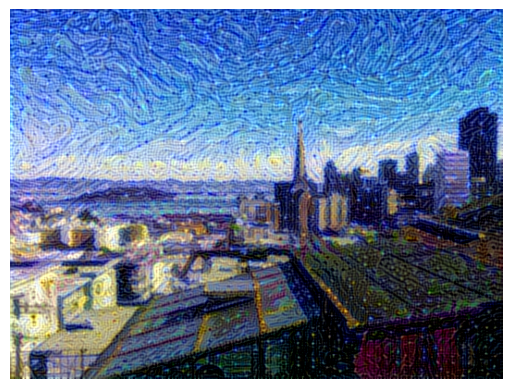

In [ ]:
# Download and load the images
base_image_path = keras.utils.get_file(
    "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg"
)
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg"
)

# Set image dimensions
original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400  # Fixed height
img_width = round(original_width * img_height / original_height)  # Maintain aspect ratio

def preprocess_image(image_path):
    """Loads and preprocesses an image for the model."""
    img = keras.utils.load_img(image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    """Converts processed image back to a displayable format."""
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939  # Undo normalization
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]  # Convert from BGR to RGB
    img = np.clip(img, 0, 255).astype("uint8")
    return img

# Load pre-trained VGG19 model (without fully connected layers)
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

# Extract outputs from specific layers
outputs_dict = {layer.name: layer.output for layer in model.layers}
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

def content_loss(base_img, combination_img):
    """Computes content loss (difference between base and generated image)."""
    return tf.reduce_sum(tf.square(combination_img - base_img))

def gram_matrix(x):
    """Computes Gram matrix for style representation."""
    x = tf.transpose(x, (2, 0, 1))  # Rearrange dimensions
    features = tf.reshape(x, (tf.shape(x)[0], -1))  # Flatten
    return tf.matmul(features, tf.transpose(features))

def style_loss(style_img, combination_img):
    """Computes style loss using Gram matrices."""
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
    """Computes total variation loss for smoothness."""
    a = tf.square(x[:, :-1, :-1, :] - x[:, 1:, :-1, :])
    b = tf.square(x[:, :-1, :-1, :] - x[:, :-1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

# Define layers for style and content extraction
style_layer_names = [
    "block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"
]
content_layer_name = "block5_conv2"

# Define weights for the losses
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    """Computes the total loss combining content, style, and variation losses."""
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())

    # Content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss += content_weight * content_loss(base_image_features, combination_features)

    # Style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        loss += (style_weight / len(style_layer_names)) * style_loss(style_reference_features, combination_features)

    # Total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)

    return loss

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    """Computes gradients for the optimization step."""
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

# Optimizer setup
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

# Load and preprocess images
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

# Run optimization loop
iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
    optimizer.apply_gradients([(grads, combination_image)])

    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

# Display final output
final_img_path = "combination_image_at_iteration_4000.png"
plt.imshow(keras.utils.load_img(final_img_path))
plt.axis('off')
plt.show()